Dans ce billet, nous allons nous intéresser aux résultats du premier tour des législatives 2017. Ce billet fait suite à mes billets précédents sur les élections présidentielles ([premier tour](http://flothesof.github.io/cartes-premier-tour-presidentielle-2017.html), [deuxième tour](http://flothesof.github.io/cartes-second-tour-presidentielle-2017.html) et utilise les mêmes techniques pour aspirer le site du ministère de l'intérieur et en faire des graphiques.

# Obtenir les données 

Tout d'abord, allons aspirer le site officiel du ministère de l'intérieur.

In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
url = 'http://elections.interieur.gouv.fr/legislatives-2017/'

In [3]:
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

Les résultats sont organisés par circonscription. Trouvons les liens vers toutes les pages relatives aux circonscriptions.

In [4]:
links = [url + tag.attrs['href'][2:] for tag in soup.find_all('a', class_='Style6')]

In [6]:
from functools import lru_cache

@lru_cache(maxsize=1024)
def fetch_page(url):
    "Fetches url for webpage."
    r = requests.get(url)
    return r

In [9]:
circo_links = []
for link in links:
    soup = BeautifulSoup(fetch_page(link).text, 'html.parser')
    circo_links += [url + tag.attrs['href'][3:] for tag in soup.find_all('a') if 'circonscription' in tag.text.lower()]

On vérifie qu'on a le bon nombre de circonscriptions.

In [10]:
len(circo_links)

577

Maintenant, nous allons pouvoir extraire les tableaux qui figurent sur les différentes pages.

In [11]:
circo_links[0]

'http://elections.interieur.gouv.fr/legislatives-2017/001/00101.html'

In [12]:
r = fetch_page(circo_links[0])

In [14]:
soup = BeautifulSoup(r.text, 'html.parser')

On peut trouver le titre de la circonscription assez facilement :

In [109]:
soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]

'Ain (01) - 1ère'

On peut récuperer une première table sur les stats liés à la circonscription.

In [35]:
import pandas as pd

In [62]:
from collections import OrderedDict

In [65]:
table = soup.find_all('tbody')[1]
votes = OrderedDict()
for row in table.find_all('tr'):
    votes[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))

In [66]:
pd.Series(votes).to_frame()

,0
Inscrits,82694
Abstentions,42063
Votants,40631
Blancs,545
Nuls,155
Exprimés,39931


Ainsi que les résultats par candidats.

In [67]:
table = soup.find_all('tbody')[0]
candidates = OrderedDict()
for row in table.find_all('tr'):
    candidates[row.td.text] = []
    for td in row.find_all('td')[1:]:
        stripped = td.text.strip().replace(',', '.').replace(' ', '')
        candidates[row.td.text].append(stripped)

In [69]:
pd.DataFrame(candidates).transpose()

,0,1,2,3,4
M. Laurent MALLET,MDM,13534,16.37,33.89,Ballotage*
M. Xavier BRETON,LR,10693,12.93,26.78,Ballotage*
M. Jérôme BUISSON,FN,6174,7.47,15.46,Non
Mme Fabrine MARTIN ZEMLIK,FI,3874,4.68,9.70,Non
Mme Florence BLATRIX-CONTAT,SOC,3687,4.46,9.23,Non
M. Jacques FONTAINE,COM,656,0.79,1.64,Non
Mme Laurane RAIMONDO,ECO,562,0.68,1.41,Non
Mme Maude LÉPAGNOT,EXG,293,0.35,0.73,Non
Mme Marie CARLIER,DIV,247,0.30,0.62,Non
M. Gilbert BONNOT,DIV,211,0.26,0.53,Non


On peut maintenant écrire une fonction qui rassemble ces extractions.

In [76]:
def extract_circo_data(url):
    "Returns data for circo: name, candidates, votes."
    r = fetch_page(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    circo_name = soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]
    table = soup.find_all('tbody')[0]
    candidates = OrderedDict()
    for row in table.find_all('tr'):
        candidates[row.td.text] = []
        for td in row.find_all('td')[1:]:
            stripped = td.text.strip().replace(',', '.').replace(' ', '')
            candidates[row.td.text].append(stripped)
    table = soup.find_all('tbody')[1]
    votes = OrderedDict()
    for row in table.find_all('tr'):
        votes[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    votes = pd.Series(votes).to_frame()
    votes.columns = [circo_name]
    return circo_name, pd.DataFrame(candidates).transpose(), votes

In [77]:
circo_name, candidates, votes = extract_circo_data(circo_links[0])

Maintenant passons aux graphiques.

# Votants par circonscription 

In [101]:
%%time
all_votes_data = [extract_circo_data(url)[2] for url in circo_links]
all_votes = pd.concat(all_votes_data, axis=1)

CPU times: user 12.9 s, sys: 389 ms, total: 13.3 s
Wall time: 1min 45s


In [102]:
all_votes

,Ain (01) - 1ère circonscription,Ain (01) - 2ème circonscription,Ain (01) - 3ème circonscription,Ain (01) - 4ème circonscription,Ain (01) - 5ème circonscription,Aisne (02) - 1ère circonscription,Aisne (02) - 2ème circonscription,Aisne (02) - 3ème circonscription,Aisne (02) - 4ème circonscription,Aisne (02) - 5ème circonscription,...,Français établis hors de France (99) - 2ème circonscription,Français établis hors de France (99) - 3ème circonscription,Français établis hors de France (99) - 4ème circonscription,Français établis hors de France (99) - 5ème circonscription,Français établis hors de France (99) - 6ème circonscription,Français établis hors de France (99) - 7ème circonscription,Français établis hors de France (99) - 8ème circonscription,Français établis hors de France (99) - 9ème circonscription,Français établis hors de France (99) - 10ème circonscription,Français établis hors de France (99) - 11ème circonscription
Inscrits,82694,93520,75614,89390,75359,72345,73981,68099,79116,82223,...,75029,120696,122765,91374,127486,105955,121399,107796,99374,92766
Abstentions,42063,47291,41131,45625,38409,36770,39857,35369,43878,41864,...,63414,95202,94943,76810,101742,78999,109986,92085,79955,67141
Votants,40631,46229,34483,43765,36950,35575,34124,32730,35238,40359,...,11615,25494,27822,14564,25744,26956,11413,15711,19419,25625
Blancs,545,471,359,521,374,517,685,639,530,609,...,36,43,68,71,47,50,41,140,175,93
Nuls,155,160,116,211,168,173,270,287,208,251,...,79,81,90,48,92,332,72,122,79,152
Exprimés,39931,45598,34008,43033,36408,34885,33169,31804,34500,39499,...,11500,25370,27664,14445,25605,26574,11300,15449,19165,25380


In [103]:
%matplotlib inline

In [107]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

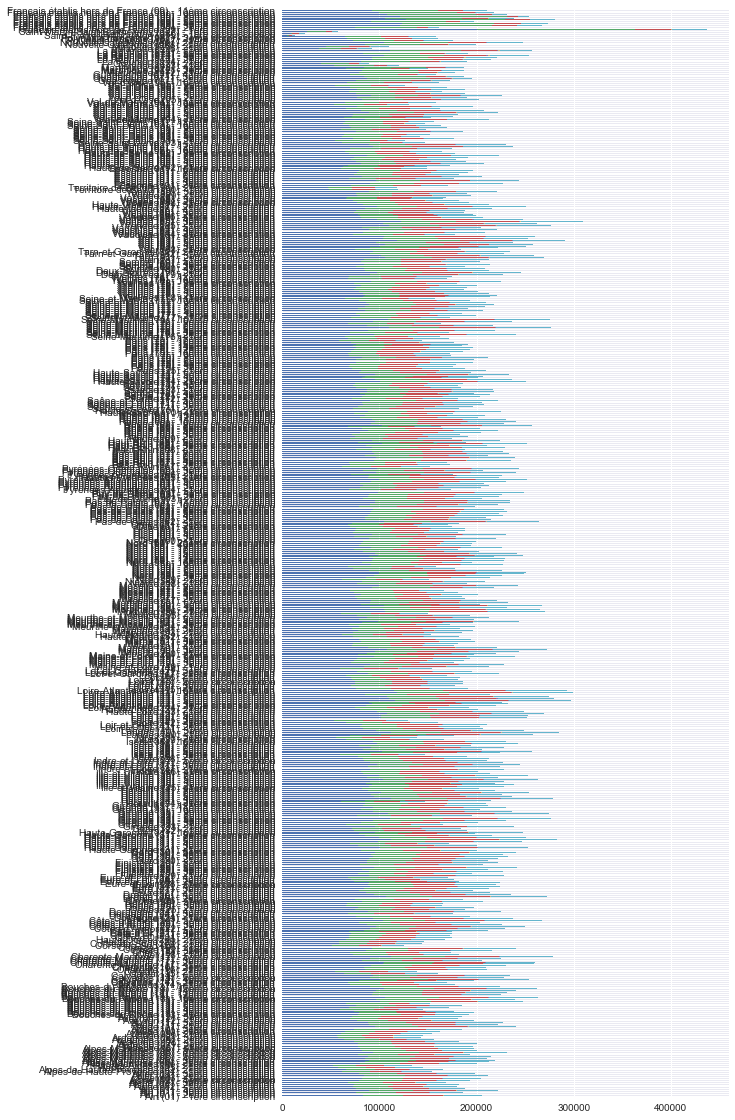

In [110]:
fig, ax = plt.subplots(figsize=(8, 20))

all_votes.transpose().plot.barh(stacked=True, legend=False, ax=ax)